# ANN Model For Churn Prediction with Imbalanced Dataset

<a id="index"></a>
## INDEX
* [Importing Packages](#packages)
* [Reading The Data](#data)
* [Data Cleaning](#cleaning)
* [Building The Model](#modelbuilding)
* [Model Evaluation](#evaluation)
* [Handling Imbalances in datasets](#handlingimbalances)
** [Technique 0 - Weights](#weights)
** [Technique 1 - Undersampling](#undersampling)
** [Technique 2 - Oversampling](#oversampling)
** [Technique 3 - Synthetic Minority Oversampling Technique (SMOTE)](#smote)
** [Technique 4 - Ensemble Learning with Undersampling](#ensemble)
* [Comparing Model Performance](#comparing)
* [References](#references)

<a id="packages"></a>
## Importing Packages
[Back To Top](#index)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score
from sklearn.utils import shuffle, class_weight

import tensorflow as tf
from tensorflow import keras

from imblearn.over_sampling import SMOTE

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

<a id="data"></a>
## Reading The Data
[Back To Top](#index)

In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,1024-GUALD,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,24.80,24.8,Yes
2715,0484-JPBRU,Male,0,No,No,41,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,No
3825,3620-EHIMZ,Female,0,Yes,Yes,52,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,1031.7,No
1807,6910-HADCM,Female,0,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,No,Electronic check,76.35,76.35,Yes
132,8587-XYZSF,Male,0,No,No,67,Yes,No,DSL,No,...,No,Yes,No,No,Two year,No,Bank transfer (automatic),50.55,3260.1,No


In [4]:
df.shape

print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset has 7043 rows and 21 columns.


In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

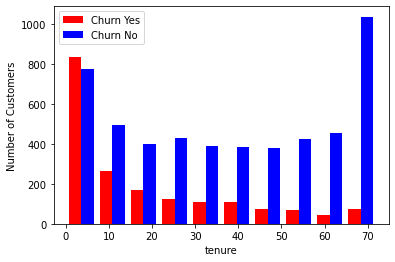

In [6]:
tenure_churn_no = df[df.Churn=="No"].tenure
tenure_churn_yes = df[df.Churn=="Yes"].tenure

plt.xlabel("tenure")
plt.ylabel("Number of Customers")

plt.hist([tenure_churn_yes, tenure_churn_no], color=["red", "blue"], label=["Churn Yes", "Churn No"])
plt.legend()

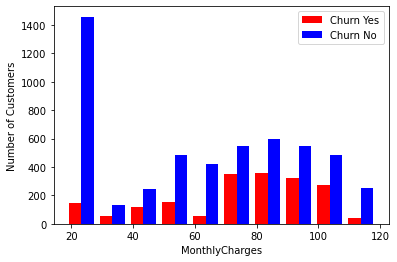

In [7]:
mc_churn_no = df[df.Churn=="No"].MonthlyCharges
mc_churn_yes = df[df.Churn=="Yes"].MonthlyCharges

plt.xlabel("MonthlyCharges")
plt.ylabel("Number of Customers")

plt.hist([mc_churn_yes, mc_churn_no], color=["red", "blue"], label=["Churn Yes", "Churn No"])
plt.legend()

<a id="cleaning"></a>
## Data Cleaning
[Back To Top](#index)

In [8]:
# dropping CustomerID column, since it is not useful for the model
df.drop("customerID", axis="columns", inplace=True)

df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

 ### __Converting object variables to float variables__

#### __Total Charges:__ Some rows have " " as value (instead of np.NaN, for example). So we can't directly convert these to numerical values.

In [9]:
df[pd.to_numeric(df.TotalCharges, errors="coerce").isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [10]:
df.iloc[488]["TotalCharges"]

' '

In [11]:
df = df[df["TotalCharges"]!= " "].reset_index(drop=True)
df.TotalCharges=pd.to_numeric(df.TotalCharges)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [13]:
def print_unique_column_values(df):
    for col in df:
        if df[col].dtypes == "object":
            print(df[col].unique())

print_unique_column_values(df)

['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['No' 'Yes']


In [14]:
df.replace("No internet service", "No", inplace=True)
df.replace("No phone service", "No", inplace=True)

print_unique_column_values(df)

['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['No' 'Yes']


In [15]:
yes_no_columns = ["Partner", "Dependents", "PhoneService", "MultipleLines",
                 "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
                 "StreamingTV", "StreamingMovies", "PaperlessBilling", "Churn"]

In [16]:
for col in yes_no_columns:
    df[col].replace({"Yes":1, "No":0}, inplace=True)
    
for col in df:
    print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [17]:
df["gender"].replace({"Female":1, "Male":0}, inplace=True)

In [18]:
df = pd.get_dummies(data=df, columns=["InternetService", "Contract", "PaymentMethod"])
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [19]:
df.shape

(7032, 27)

In [20]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

## Scaling columns with range not between 0-1

In [21]:
cols_to_scale = ["tenure", "MonthlyCharges", "TotalCharges"]

scaler = MinMaxScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df.tenure

0       0.000000
1       0.464789
2       0.014085
3       0.619718
4       0.014085
          ...   
7027    0.323944
7028    1.000000
7029    0.140845
7030    0.042254
7031    0.915493
Name: tenure, Length: 7032, dtype: float64

<a id="modelbuilding"></a>
## Building The Model
[Back To Top](#index)

In [22]:
X = df.drop("Churn", axis = "columns")
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print(X_train.shape)
print(X_test.shape)

(5625, 26)
(1407, 26)


In [23]:
model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,), activation = "relu"),
    keras.layers.Dense(15, activation = "relu"),
    keras.layers.Dense(1, activation = "sigmoid")
])
model.compile(optimizer = "adam",
              loss="binary_crossentropy",
              metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
176/176 [==============================] - 1s 2ms/step - loss: 0.4803 - accuracy: 0.7616
Epoch 2/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.7961
Epoch 3/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4160 - accuracy: 0.8023
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4120 - accuracy: 0.8059
Epoch 5/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4106 - accuracy: 0.8053: 0s - loss: 0.4121 - accuracy: 
Epoch 6/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4085 - accuracy: 0.8060
Epoch 7/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4066 - accuracy: 0.8078
Epoch 8/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4052 - accuracy: 0.8130
Epoch 9/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4050 - accuracy: 0.8082
Epoch 10/100
176/176 [==============================] - 0s 

<a id="evaluation"></a>
## Model Evaluation
[Back To Top](#index)

In [24]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 1ms/step - loss: 0.5069 - accuracy: 0.7690


[0.506879985332489, 0.7690120935440063]

In [25]:
y_pred = np.round(model.predict(X_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       999
           1       0.64      0.45      0.53       408

    accuracy                           0.77      1407
   macro avg       0.72      0.68      0.69      1407
weighted avg       0.76      0.77      0.76      1407



In [26]:
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.4534313725490196
0.5323741007194245


Both F1 scores and recall are too low for this model to be useful.

Text(33.0, 0.5, 'Truth')

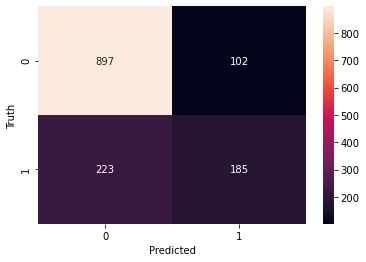

In [27]:
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)

sn.heatmap(cm, annot=True, fmt="d")

plt.xlabel("Predicted")
plt.ylabel("Truth")

Since our goal is to build a model that detects as many "churners" as possible (to potentially prevent them from leaving the service), we will want our recall score to be as high as possible. However, often companies have limited resources to prevent churners from leaving their service, so F1 and accuracy should also be considered.

In [28]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy with weights: ", acc)
print("Recall with weights: ", recall)
print("F1 score with weights: ", f1)

Accuracy with weights:  0.7690120824449183
Recall with weights:  0.4534313725490196
F1 score with weights:  0.5323741007194245


<a id="handlingimbalances"></a>
## Handling Imbalances in the dataset

<a id="weights"></a>
### __Technique 0: Using Weights__
[Back To Top](#index)

In [29]:
y.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [30]:
weight_for_0 = (1 / y.value_counts()[0]) * (sum(y.value_counts()) / 2.0)
weight_for_1 = (1 / y.value_counts()[1]) * (sum(y.value_counts()) / 2.0)

weights = {0: weight_for_0, 1: weight_for_1}

In [31]:
def ANN(xtrain, ytrain, xtest, ytest, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_shape=(26,), activation = "relu"),
        keras.layers.Dense(15, activation = "relu"),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(optimizer = "adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"]
    )
    
    if weights == None:
        model.fit(xtrain, ytrain, epochs=100)
    else:
        model.fit(xtrain, ytrain, epochs=100, class_weight=weights)
    
    y_pred = np.round(model.predict(xtest))
    
    return y_pred

In [32]:
y_preds = ANN(X_train, y_train, X_test, y_test, "binary_crossentropy", weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
176/176 [==============================] - 1s 2ms/step - loss: 0.5665 - accuracy: 0.7173
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4967 - accuracy: 0.7460
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4862 - accuracy: 0.7490
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.7467
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4775 - accuracy: 0.7570
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4748 - accuracy: 0.7532
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4720 - accuracy: 0.7543
Epoch 8/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.7563
Epoch 9/100
176/176 [==============================] -

In [33]:
acc_weights = accuracy_score(y_test, y_preds)
recall_weights = recall_score(y_test, y_preds)
f1_weights = f1_score(y_test, y_preds)

print("Accuracy with weights: ", acc_weights)
print("Recall with weights: ", recall_weights)
print("F1 score with weights: ", f1_weights)

Accuracy with weights:  0.7412935323383084
Recall with weights:  0.6838235294117647
F1 score with weights:  0.6052060737527114


<a id="undersampling"></a>
### __Technique 1: Undersampling__
[Back To Top](#index)

In [34]:
samples_0 = len(df[df["Churn"]==0])
samples_1 = len(df[df["Churn"]==1])
print(f"Number of churns in our original dataset: {samples_1}")

df_class_0 = df[df["Churn"]==0]
df_class_1 = df[df["Churn"]==1]

df_undersampled = pd.concat([df_class_0.sample(len(df_class_1)), df_class_1], axis=0)
df_undersampled.head(3)

Number of churns in our original dataset: 1869


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
350,0,0,1,1,0.507042,1,1,1,0,1,...,1,0,0,0,0,1,0,1,0,0
5301,0,0,1,0,0.591549,1,1,1,1,0,...,1,0,0,1,0,0,1,0,0,0
5174,0,0,0,0,0.154930,1,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0


In [35]:
print(df_undersampled.Churn.value_counts())

0    1869
1    1869
Name: Churn, dtype: int64


In [36]:
X = df_undersampled.drop("Churn", axis = "columns")
y = df_undersampled.Churn

# stratify will make sure my samples are balanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

print(X_train.shape)
print(X_test.shape)

(2990, 26)
(748, 26)


In [37]:
y_train.value_counts()

0    1495
1    1495
Name: Churn, dtype: int64

In [38]:
y_preds = ANN(X_train, y_train, X_test, y_test, "binary_crossentropy", weights=None)

Epoch 1/100
94/94 [==============================] - 1s 2ms/step - loss: 0.6134 - accuracy: 0.6649
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5213 - accuracy: 0.7441
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7538
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4982 - accuracy: 0.7615
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4942 - accuracy: 0.7656
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.7659
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4891 - accuracy: 0.7649
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.7692
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.7649
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4822 - accuracy: 0.7726
Epoch 11/

In [39]:
acc_under = accuracy_score(y_test, y_preds)
recall_under = recall_score(y_test, y_preds)
f1_under = f1_score(y_test, y_preds)

print("Accuracy with undersampling: ", acc_under)
print("Recall with undersampling: ", recall_under)
print("F1 score with undersampling: ", f1_under)

Accuracy with undersampling:  0.7526737967914439
Recall with undersampling:  0.7352941176470589
F1 score with undersampling:  0.7482993197278912


<a id="oversampling"></a>
### __Technique 2: Oversampling__
[Back To Top](#index)

In [40]:
samples_0, samples_1

(5163, 1869)

In [41]:
df_oversampled = pd.concat([df_class_0, df_class_1.sample(samples_0, replace=True)])

print(df_oversampled.Churn.value_counts())

0    5163
1    5163
Name: Churn, dtype: int64


In [42]:
X = df_oversampled.drop("Churn", axis = "columns")
y = df_oversampled.Churn

# stratify will make sure my samples are balanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

print(X_train.shape)
print(X_test.shape)

(8260, 26)
(2066, 26)


In [43]:
y_train.value_counts()

0    4130
1    4130
Name: Churn, dtype: int64

In [44]:
y_preds = ANN(X_train, y_train, X_test, y_test, "binary_crossentropy", None)

Epoch 1/100
259/259 [==============================] - 1s 2ms/step - loss: 0.5281 - accuracy: 0.7390
Epoch 2/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4910 - accuracy: 0.7590
Epoch 3/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4836 - accuracy: 0.7638
Epoch 4/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4777 - accuracy: 0.7671
Epoch 5/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4737 - accuracy: 0.7691
Epoch 6/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4715 - accuracy: 0.7711
Epoch 7/100
259/259 [==============================] - 0s 969us/step - loss: 0.4675 - accuracy: 0.7742
Epoch 8/100
259/259 [==============================] - 0s 930us/step - loss: 0.4641 - accuracy: 0.7747
Epoch 9/100
259/259 [==============================] - 0s 868us/step - loss: 0.4626 - accuracy: 0.7783
Epoch 10/100
259/259 [==============================] - 0s 911us/step - loss: 0.4607 

In [45]:
acc_over = accuracy_score(y_test, y_preds)
recall_over = recall_score(y_test, y_preds)
f1_over = f1_score(y_test, y_preds)

print("Accuracy with oversampling: ", acc_over)
print("Recall with oversampling: ", recall_over)
print("F1 score with oversampling: ", f1_over)

Accuracy with oversampling:  0.8054211035818006
Recall with oversampling:  0.8451113262342691
F1 score with oversampling:  0.8128491620111731


<a id="smote"></a>
### __Technique 3: Synthetic Minority Oversampling Technique (SMOTE)__
SMOTE synthesize new examples from the minority class using k nearest neighbors. The default is k=5
* Documentation: https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html

[Back To Top](#index)

In [46]:
X = df.drop("Churn", axis="columns")
y = df["Churn"]

print("Shape of X, y originally:")
print(X.shape)
print(y.shape)

smote = SMOTE(sampling_strategy="minority")

X_sm, y_sm = smote.fit_resample(X, y) # default: k = 5

print("\nShape of X_sm, y_sm after SMOTE:")
print(X_sm.shape)
print(y_sm.shape)

y_sm.value_counts()

Shape of X, y originally:
(7032, 26)
(7032,)

Shape of X_sm, y_sm after SMOTE:
(10326, 26)
(10326,)


0    5163
1    5163
Name: Churn, dtype: int64

In [47]:
# stratify will make sure my samples are balanced
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=5, stratify=y_sm)

print(X_train.shape)
print(X_test.shape)

(8260, 26)
(2066, 26)


In [48]:
y_test.value_counts()

0    1033
1    1033
Name: Churn, dtype: int64

In [49]:
y_preds = ANN(X_train, y_train, X_test, y_test, "binary_crossentropy", None)

Epoch 1/100
259/259 [==============================] - 1s 2ms/step - loss: 0.5256 - accuracy: 0.7538
Epoch 2/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4703 - accuracy: 0.7759
Epoch 3/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.7808
Epoch 4/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4548 - accuracy: 0.7831
Epoch 5/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4486 - accuracy: 0.7896
Epoch 6/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.7910
Epoch 7/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4405 - accuracy: 0.7935
Epoch 8/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4374 - accuracy: 0.7953
Epoch 9/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4348 - accuracy: 0.7989
Epoch 10/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4315 - accura

In [50]:
acc_smote = accuracy_score(y_test, y_preds)
recall_smote = recall_score(y_test, y_preds)
f1_smote = f1_score(y_test, y_preds)

print("Accuracy with SMOTE: ", acc_smote)
print("Recall with SMOTE: ", recall_smote)
print("F1 score with SMOTE: ", f1_smote)

Accuracy with SMOTE:  0.8252662149080349
Recall with SMOTE:  0.8441432720232332
F1 score with SMOTE:  0.8285035629453681


<a id="ensemble"></a>
### __Technique 4: Ensemble Learning with Undersampling__
[Back To Top](#index)

In [51]:
X = df.drop("Churn", axis="columns")
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

In [52]:
y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

In [53]:
n_batches = round(4130/1495,0)
n_batches

3.0

In [54]:
df_train = X_train.copy()
df_train["Churn"] = y_train

df_train_class0 = df_train[df_train["Churn"]==0]
df_train_class1 = df_train[df_train["Churn"]==1]

In [55]:
df_train_class0.shape, df_train_class1.shape

((4130, 27), (1495, 27))

In [56]:
df_train_class0.sample(1495).shape

(1495, 27)

In [57]:
df_train_class0_shuffled = shuffle(df_train_class0)

df_train_class0_batch1 = df_train_class0_shuffled[:1495]
df_train_class0_batch2 = df_train_class0_shuffled[1495:1495*2]
df_train_class0_batch3 = df_train_class0_shuffled[-1495:]

In [58]:
y_preds_batches = []

for batch in [df_train_class0_batch1, df_train_class0_batch2, df_train_class0_batch3]:
    df_train = pd.concat([batch, df_train_class1], axis=0)

    X_train = df_train.drop("Churn", axis="columns")
    y_train = df_train.Churn
    
    y_preds = ANN(X_train, y_train, X_test, y_test, "binary_crossentropy", None)
    y_preds_batches.append(y_preds)

Epoch 1/100
94/94 [==============================] - 1s 2ms/step - loss: 0.6136 - accuracy: 0.6809
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5110 - accuracy: 0.7555
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4985 - accuracy: 0.7629
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4927 - accuracy: 0.7662
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4882 - accuracy: 0.7716
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4853 - accuracy: 0.7669
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4811 - accuracy: 0.7753
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4786 - accuracy: 0.7766
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4753 - accuracy: 0.7763
Epoch 10/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4738 - accuracy: 0.7786
Epoch 11/

In [59]:
y_preds_ensemble = []

for i in range(len(y_preds_batches[0])):
    n_ones = y_preds_batches[0][i] + y_preds_batches[1][i] + y_preds_batches[2][i]
    y_preds_ensemble.append(int(np.round(n_ones/3)))

In [60]:
acc_ensemble = accuracy_score(y_test, y_preds_ensemble)
recall_ensemble = recall_score(y_test, y_preds_ensemble)
f1_ensemble = f1_score(y_test, y_preds_ensemble)

print("Accuracy with Ensemble Learning with Undersampling: ", acc_ensemble)
print("Recall with Ensemble Learning with Undersampling: ", recall_ensemble)
print("F1 score with Ensemble Learning with Undersampling: ", f1_ensemble)

Accuracy with Ensemble Learning with Undersampling:  0.7420042643923241
Recall with Ensemble Learning with Undersampling:  0.7513368983957219
F1 score with Ensemble Learning with Undersampling:  0.6075675675675676


<a id="comparing"></a>
### __Model Comparison__
[Back To Top](#index)

In [61]:
results = {"Accuracy": [acc, acc_weights, acc_under, acc_over, acc_smote, acc_ensemble],
                   "Recall": [recall, recall_weights, recall_under, recall_over, recall_smote, recall_ensemble],
                   "F1 Score": [f1, f1_weights, f1_under, f1_over, f1_smote, f1_ensemble]}

model_comparison = pd.DataFrame(data=results, index=["Original", "Weights", "Undersampling", "Oversampling", "SMOTE", "Esemble"])

display(model_comparison.round(2))

,Accuracy,Recall,F1 Score
Original,0.77,0.45,0.53
Weights,0.74,0.68,0.61
Undersampling,0.75,0.74,0.75
Oversampling,0.81,0.85,0.81
SMOTE,0.83,0.84,0.83
Esemble,0.74,0.75,0.61


In this case, ANN with Oversampling and SMOTE worked the best.

<a id="references"></a>
### __References__
[Back To Top](#index)

This project was based off of CodeBasics project: 
* https://www.youtube.com/watch?v=MSBY28IJ47U
* https://www.youtube.com/watch?v=JnlM4yLFNuo

Dataset: 
* https://www.kaggle.com/blastchar/telco-customer-churn